# SpikeInterface Tutorial -  SI version > 0.90 - August 2021


In this tutorial, we will cover the basics of using SpikeInterface for extracellular analysis and spike sorting comparison. 
We will be using the `spikeinterface` version>0.90 and highlight API changes from the previous versions (<=0.12). 

For this analysis, we will use a 64-channel dataset from am "ASSY-156-P1" probe from Cambridge Neurotech. The dataset is provided by Samuel McKenzie's Lab. 

We recommend creating a new `spiketutorial` conda environment using:

`conda env create -f environment.yml`


Alternatively, you can install the requirements you can use the `requirements.txt` in this directory by running the command:

`pip install -r requirements.txt`

# Table of contents

* [0. Preparation](#preparation)
* [1. Loading the data and probe information](#loading)
* [2. Preprocessing](#preprocessing)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Validation and curation](#curation)
* [8. Spike sorting comparison](#comparison)
* [9. Exporters](#exporters)

# 0. Preparation <a class="anchor" id="preparation"></a>

### Download the ephys data

First, we need to download the recording. Feel free to use your own recordings as well later on. 
From this Zenodo [link](https://doi.org/10.5281/zenodo.4657314), you can download the dataset mentioned above (`cambridge_data.bin`). Move the dataset in the current folder and unzip it.
The recording was performed with the "ASSY-156-P1" probe with 4 shanks of 16 channels (in total 64 channels).


### Import the modules

Let's now import the `spikeinterface` modules that we need:

In [1]:
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

# 1. Loading recording and probe information <a class="anchor" id="loading"></a>

In [3]:
# file path
recording_file = 'cambridge_data.bin'

# parameters to load the bin/dat format
num_channels = 64
sampling_frequency = 20000
gain_to_uV = 0.195
offset_to_uV = 0
dtype="int16"
time_axis = 1

In [4]:
recording = si.read_binary(recording_file, num_chan=num_channels, sampling_frequency=sampling_frequency,
                           dtype=dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis)

The `read_binary()` function returns a `RecordingExtractor` object. We can print it to visualize some of its properties:

In [5]:
print(recording)

BinaryRecordingExtractor: 64 channels - 1 segments - 20.0kHz - 600.000s
  file_paths: ['/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_0.90_Aug2021/cambridge_data.bin']


We can further `annotate` the recording to tell SI that it is not filtered yet. This will prevent further mistakes in the pipieline, such as attempting to extract waveforms from unfiltered data.

In [6]:
recording.annotate(is_filtered=False)

While the `read_binary()` function is part of the `core` module (as it's used internally by SI to store data in a convenient format), the `extractor` module allows you to load many file formats used in electrophysiology. 

The extractors available in SI are all loaded using the [NEO](https://neo.readthedocs.io/en/stable/) python package.

We can access the full list of available extractors with:

In [7]:
se.recording_extractor_full_list

[spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor,
 spikeinterface.core.numpyextractors.NumpyRecording,
 spikeinterface.extractors.shybridextractors.SHYBRIDRecordingExtractor,
 spikeinterface.extractors.mdaextractors.MdaRecordingExtractor,
 spikeinterface.extractors.neoextractors.mearec.MEArecRecordingExtractor,
 spikeinterface.extractors.neoextractors.spikeglx.SpikeGLXRecordingExtractor,
 spikeinterface.extractors.neoextractors.openephys.OpenEphysLegacyRecordingExtractor,
 spikeinterface.extractors.neoextractors.openephys.OpenEphysBinaryRecordingExtractor,
 spikeinterface.extractors.neoextractors.intan.IntanRecordingExtractor,
 spikeinterface.extractors.neoextractors.neuroscope.NeuroScopeRecordingExtractor,
 spikeinterface.extractors.neoextractors.plexon.PlexonRecordingExtractor,
 spikeinterface.extractors.neoextractors.neuralynx.NeuralynxRecordingExtractor,
 spikeinterface.extractors.neoextractors.blackrock.BlackrockRecordingExtractor,
 spikeinterface.extractors.

A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). The `BinaryRecordingExtractor` is designed specifically for raw binary files datasets (.bin, .dat, .raw).

Here we load information from the recording using the built-in functions from the RecordingExtractor

In [8]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_segments = recording.get_num_segments()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f"Number of segments: {num_segments}")

Channel ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Sampling frequency: 20000
Number of channels: 64
Number of segments: 1


**NEW:** The new SI version supports multi-segment recordings. A segment is a contiguous piece of data, and sometimes recordings can be made of multiple acquisitions, for examples a baseline, a stimulation phase, and a post recording. In such cases, the recording object will be made of multiple segments and be treated as such over the pipeline.

The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

In [9]:
trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [10]:
print('Traces shape:', trace_snippet.shape)

Traces shape: (40000, 64)


The `widgets` module includes several convenient plotting functions that can be used to explore the data:

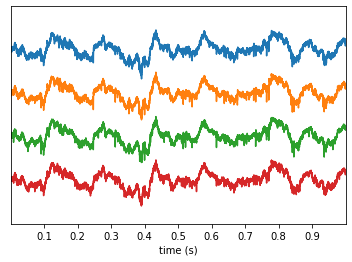

In [11]:
w_ts = sw.plot_timeseries(recording, channel_ids=[0, 1, 2, 3])

Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://gin.g-node.org/spikeinterface/probeinterface_library/) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

In [12]:
import probeinterface as pi
from probeinterface import plotting

In [13]:
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-156-P-1'

probe = pi.get_probe(manufacturer, probe_name)
print(probe)

cambridgeneurotech - ASSY-156-P-1 - 64ch


In most experiments, the neural probe has a connector, that is interfaced to an headstage, which in turn connects to the acquisition system. This *pathway* usually results in a channel remapping, which means that the order of the contacts on the probe is different than the order of the recorded traces.

`probeinterface` provides a growing collection of common pathways that can be loaded directly to wire a device and apply the correct channel mapping:

In [14]:
pi.get_available_pathways()

['H32>RHD2132', 'ASSY-156>RHD2164', 'ASSY-77>Adpt.A64-Om32_2x-sm>RHD2164']

In [15]:
probe.wiring_to_device('ASSY-156>RHD2164')

(<matplotlib.collections.PolyCollection at 0x7fec76bc81f0>,
 <matplotlib.collections.PolyCollection at 0x7fec76c75820>)

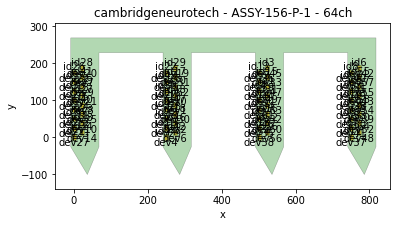

In [16]:
plotting.plot_probe(probe, with_contact_id=True, with_device_index=True)

The probe now has contact ids `id#` and device ids `dev#`! We can also visualize the probe information as a `pandas` dataframe:

In [17]:
probe.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

contact_ids shank_ids  device_channel_indices
0            1         2                      47
1            2         2                      46
2            3         2                      45
3            4         2                      44
4            5         3                      43
..         ...       ...                     ...
59          60         3                      52
60          61         3                      51
61          62         3                      50
62          63         3                      49
63          64         3                      48

[64 rows x 3 columns]

Note that also the `shank_id` is loaded with the probe.

**NEW:** A `probeinterface` object can be loaded directly to a SI recording object:

In [18]:
recording_prb = recording.set_probe(probe, group_mode="by_shank")

When loading the probe, the device indices (and all the other contact properties) are automatically sorted:

In [19]:
probe_rec = recording_prb.get_probe()
probe_rec.to_dataframe(complete=True).loc[:, ["contact_ids", "shank_ids", "device_channel_indices"]]

contact_ids shank_ids  device_channel_indices
0           48         1                       0
1           47         1                       1
2           46         1                       2
3           45         1                       3
4           44         1                       4
..         ...       ...                     ...
59          53         2                      59
60          52         2                      60
61          51         2                      61
62          50         1                      62
63          49         2                      63

[64 rows x 3 columns]

In [20]:
print(f'Channels after loading the probe file: {recording_prb.get_channel_ids()}')
print(f'Channel groups after loading the probe file: {recording_prb.get_channel_groups()}')

Channels after loading the probe file: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
Channel groups after loading the probe file: [1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 2 1 1 0 0 0 0 0 0 1 0 1 1 1 1 2 2 2 2 2
 3 3 3 3 3 3 3 2 2 2 2 3 3 3 3 3 3 3 3 2 3 2 2 2 2 1 2]


### Properties 

`RecordingExtractor` object can have *properties*. A property is a piece of information attached to a channel, e.g. group or location.

Similarly, for `SortingExtractor` objects (that we'll cover later), anything related to a unit can be stored as a property. 

We can check which properties are in the extractor as follows:

In [21]:
print("Properties before loading the probe:", list(recording.get_property_keys()))

Properties before loading the probe: ['gain_to_uV', 'offset_to_uV']


In [22]:
print("Properties after loading the probe:", list(recording_prb.get_property_keys()))

Properties after loading the probe: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group']


After loading the probe we now have some new properties: `contact_vector`, `location`, and `group`.

Let's add some new properties! 
The first 32 channels are in the CA1 area, the second 32 are in the CA3 area:

In [23]:
brain_area_property_values = ['CA1']*32 + ['CA3']*32
print(brain_area_property_values)

['CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA1', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3', 'CA3']


In [24]:
recording_prb.set_property(key='brain_area', values=brain_area_property_values)

We can also specify a property on a subset of channels. In this case, the non-specified channels will be filled empty values:

In [25]:
recording_prb.set_property(key='quality', values=["good"]*(recording_prb.get_num_channels() - 3),
                           ids=recording_prb.get_channel_ids()[:-3])

In [26]:
recording_prb.get_property("quality")

array(['good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', '', '', ''], dtype='<U4')

In [27]:
print("Properties after adding custom properties:", list(recording_prb.get_property_keys()))

Properties after adding custom properties: ['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'brain_area', 'quality']


**NOTE:** Internally the properties is jus a dictionary attached to the recording that is accessible as `_properties`

In [28]:
print(recording_prb._properties.keys())

dict_keys(['gain_to_uV', 'offset_to_uV', 'contact_vector', 'location', 'group', 'brain_area', 'quality'])


### Annotations

*Annotations* can be attached to any object and they can carry any information related to the recording or sorting objects.

Let's add an annotation about this tutorial:

In [29]:
recording_prb.annotate(description="Dataset for SI 0.90 tutorial")

In [30]:
print(recording_prb.get_annotation_keys())

['is_filtered', 'probe_0_planar_contour', 'description']


# 2. Preprocessing <a class="anchor" id="preprocessing"></a>


Now that the probe information is loaded we can do some preprocessing using `toolkit` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

We will focus only on the first shank (grouo `0`) for the following analysis:

In [31]:
recordings_by_group = recording_prb.split_by("group")
print(recordings_by_group)

{0: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 1: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 2: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s, 3: ChannelSliceRecording: 16 channels - 1 segments - 20.0kHz - 600.000s}


In [32]:
recording_to_process = recordings_by_group[0]

Below, we bandpass filter the recording and apply common median reference to the original recording:

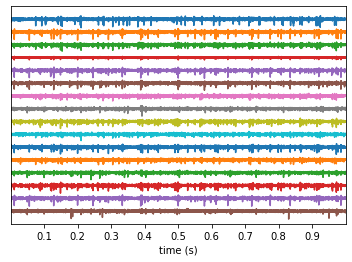

In [33]:
recording_f = st.bandpass_filter(recording_to_process, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(recording_f)

We can see that the after filtering we can observe spiking activity on many channels! We can also apply other preprocessing steps to further increase the quality of the recording. 

For examplem let's apply Common Median Reference (CMR)

In [34]:
recording_cmr = st.common_reference(recording_f, reference='global', operator='median')

We can plot the traces after applying CMR:

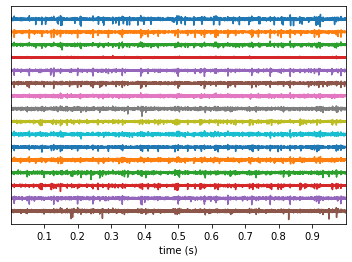

In [35]:
w = sw.plot_timeseries(recording_cmr)

Since we are going to spike sort the data, let's first cut out a 5-minute recording, to speed up computations.

We can easily do so with the `frame_slice()` function:

In [36]:
fs = recording_cmr.get_sampling_frequency()
recording_sub = recording_cmr.frame_slice(start_frame=0*fs, end_frame=300*fs)

# 3. Saving and loading SpikeInterface objects <a class="anchor" id="save-load"></a>

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to **save** it to a file and perform those operations (eg. filters, CMR, etc.) at once. 

In [37]:
recording_saved = recording_sub.save(folder="preprocessed", progress_bar=True, 
                                     n_jobs=4, total_memory="100M")

write_binary_recording with n_jobs 4  chunk_size 781250


write_binary_recording: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.82it/s]


If we inspect the `preprocessed` folder, we find that a few files have been saved. Let's take a look at what they are:

In [38]:
!ls preprocessed/

cached.json            properties             traces_cached_seg0.raw
probe.json             provenance.json


The `traces_cached_seg0.raw` contains the processed raw data, while the `.json` files include information on how to reload the binary file. The `provenance.json` includes the information of the recording before saving it to a binary file, and the `probe.json` represents the probe object. 

In [39]:
!cat preprocessed/provenance.json

{
    "class": "spikeinterface.core.frameslicerecording.FrameSliceRecording",
    "module": "spikeinterface",
    "kwargs": {
        "parent_recording": {
            "class": "spikeinterface.toolkit.preprocessing.common_reference.CommonReferenceRecording",
            "module": "spikeinterface",
            "kwargs": {
                "recording": {
                    "class": "spikeinterface.toolkit.preprocessing.filter.BandpassFilterRecording",
                    "module": "spikeinterface",
                    "kwargs": {
                        "recording": {
                            "class": "spikeinterface.core.channelslicerecording.ChannelSliceRecording",
                            "module": "spikeinterface",
                            "kwargs": {
                                "parent_recording": {
                                    "class": "spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor",
                                    "module": "spikeint

In [40]:
!cat preprocessed/cached.json

{
    "class": "spikeinterface.core.binaryrecordingextractor.BinaryRecordingExtractor",
    "module": "spikeinterface",
    "kwargs": {
        "file_paths": [
            "traces_cached_seg0.raw"
        ],
        "sampling_frequency": 20000,
        "num_chan": 16,
        "dtype": "<f4",
        "channel_ids": [
            7,
            8,
            9,
            10,
            11,
            12,
            13,
            14,
            15,
            20,
            21,
            22,
            23,
            24,
            25,
            27
        ],
        "time_axis": 0,
        "file_offset": 0,
        "gain_to_uV": [
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195,
            0.195
        ],
        "offset_to_uV": [
     

As you can see by inspecting the files, the `provenance.json` contains all the information anout the `recording_sub` object (started off as a `BinaryRecording` and had a bandpass filter, a CMR, and a frame slice operation applied to it). The `cached.json` instead directly points to the `traces_cached_seg0.raw` file.

The `properties` folder stores all the properties in `.npy` format:

In [41]:
!ls preprocessed/properties/

brain_area.npy     gain_to_uV.npy     location.npy       quality.npy
contact_vector.npy group.npy          offset_to_uV.npy


The `save` returns a new *cached* recording that has all the previously loaded information:

In [42]:
print(f'Cached channels ids: {recording_saved.get_channel_ids()}')
print(f'Channel groups after caching: {recording_saved.get_channel_groups()}')

Cached channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after caching: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


After saving the SI object, we can easily load it back in a new session:

In [43]:
recording_loaded = si.load_extractor("preprocessed/")

In [44]:
print(f'Loaded channels ids: {recording_loaded.get_channel_ids()}')
print(f'Channel groups after loading: {recording_loaded.get_channel_groups()}')

Loaded channels ids: [ 7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 27]
Channel groups after loading: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can double check that the traces are exactly the same as the `recording_saved` that we saved:

Text(0.5, 1.0, 'Loaded')

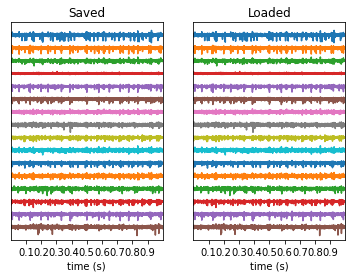

In [45]:
fig, axs = plt.subplots(ncols=2)
w_saved = sw.plot_timeseries(recording_saved, ax=axs[0])
w_loaded = sw.plot_timeseries(recording_loaded, ax=axs[1])
axs[0].set_title("Saved")
axs[1].set_title("Loaded")

**IMPORTANT**: the same saving mechanisms are available also for all SortingExtractor

# 4. Spike sorting <a class="anchor" id="spike-sorting"></a>

We can now run spike sorting on the above recording. We will use `herdingspikes` and `ironclust` for this demonstration, to show how easy SpikeInterface makes it easy to interchengably run different sorters :)

Let's first check the installed sorters in spiketoolkit to see if herdingspikes is available. Then we can then check the `herdingspikes` default parameters.
We will sort the bandpass cached filtered recording the `recoridng_saved` object.

In [46]:
ss.installed_sorters()

['herdingspikes']

We can retrieve the parameters associated to any sorter with the `get_default_params()` function from the `sorters` module:

In [47]:
ss.get_default_params('herdingspikes')

{'clustering_bandwidth': 5.5,
 'clustering_alpha': 5.5,
 'clustering_n_jobs': -1,
 'clustering_bin_seeding': True,
 'clustering_min_bin_freq': 16,
 'clustering_subset': None,
 'left_cutout_time': 0.3,
 'right_cutout_time': 1.8,
 'detect_threshold': 20,
 'probe_masked_channels': [],
 'probe_inner_radius': 70,
 'probe_neighbor_radius': 90,
 'probe_event_length': 0.26,
 'probe_peak_jitter': 0.2,
 't_inc': 100000,
 'num_com_centers': 1,
 'maa': 12,
 'ahpthr': 11,
 'out_file_name': 'HS2_detected',
 'decay_filtering': False,
 'save_all': False,
 'amp_evaluation_time': 0.4,
 'spk_evaluation_time': 1.0,
 'pca_ncomponents': 2,
 'pca_whiten': True,
 'freq_min': 300.0,
 'freq_max': 6000.0,
 'filter': True,
 'pre_scale': True,
 'pre_scale_value': 20.0,
 'filter_duplicates': True}

In [48]:
ss.get_params_description('herdingspikes')

{'clustering_bandwidth': 'Meanshift bandwidth, average spatiel extent of spike clusters (um)',
 'clustering_alpha': 'Scalar for the waveform PC features when clustering.',
 'clustering_n_jobs': 'Number of cores to use for clustering.',
 'clustering_bin_seeding': 'Enable clustering bin seeding.',
 'clustering_min_bin_freq': 'Minimum spikes per bin for bin seeding.',
 'clustering_subset': 'Number of spikes used to build clusters. All by default.',
 'left_cutout_time': 'Cutout size before peak (ms).',
 'right_cutout_time': 'Cutout size after peak (ms).',
 'detect_threshold': 'Detection threshold',
 'probe_masked_channels': 'Masked channels',
 'probe_inner_radius': 'Radius of area around probe channel for localization',
 'probe_neighbor_radius': 'Radius of area around probe channel for neighbor classification.',
 'probe_event_length': 'Duration of a spike event (ms)',
 'probe_peak_jitter': 'Maxmimum peak misalignment for synchronous spike (ms)',
 't_inc': 'Number of samples per chunk durin

In [49]:
ss.run_sorter?

In [50]:
ss.run_herdingspikes?

To modify a parameter, we can easily pass it to the `run` function as an extra argument!
For example, let's set the `filter` parameter to False as the recording is already preprocessed:

In [51]:
# run spike sorting on entire recording
sorting_HS = ss.run_herdingspikes(recording_saved, output_folder='results_HS', 
                                  filter=False, verbose=True)
print('Found', len(sorting_HS.get_unit_ids()), 'units')

Herdingspikes use the OLD spikeextractors with RecordingExtractorOldAPI
# Generating new position and neighbor files from data file
# Not Masking any Channels
# Sampling rate: 20000
# Localization On
# Number of recorded channels: 16
# Analysing frames: 6000000; Seconds: 300.0
# Frames before spike in cutout: 6
# Frames after spike in cutout: 36
# tcuts: 26 56
# tInc: 100000
# Analysing frames from -26 to 100056  (0.0%)
# Analysing frames from 99974 to 200056  (1.7%)
# Analysing frames from 199974 to 300056  (3.3%)
# Analysing frames from 299974 to 400056  (5.0%)
# Analysing frames from 399974 to 500056  (6.7%)
# Analysing frames from 499974 to 600056  (8.3%)
# Analysing frames from 599974 to 700056  (10.0%)
# Analysing frames from 699974 to 800056  (11.7%)
# Analysing frames from 799974 to 900056  (13.3%)
# Analysing frames from 899974 to 1000056  (15.0%)
# Analysing frames from 999974 to 1100056  (16.7%)
# Analysing frames from 1099974 to 1200056  (18.3%)
# Analysing frames from 1199

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.7s remaining:    6.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.8s finished


Number of estimated units: 19
Saving to results_HS/HS2_sorted.hdf5
herdingspikes run time 7.05s
Found 19 units


SpikeInterface ensures full provenance of the spike sorting pipeline. Upon running a spike sorter, a `spikeinterface_params.json` file is saved in the `output_folder`. This contains a `.json` version of the recording and all the input parameters. 

In [52]:
!ls results_hs/

HS2_detected.bin
HS2_detectedDetectionDict2021-08-25_162322_160894.txt
HS2_sorted.hdf5
spikeinterface_log.json
spikeinterface_params.json
spikeinterface_recording.json


In [53]:
!cat results_hs/spikeinterface_params.json

{
    "sorter_name": "herdingspikes",
    "sorter_params": {
        "clustering_bandwidth": 5.5,
        "clustering_alpha": 5.5,
        "clustering_n_jobs": -1,
        "clustering_bin_seeding": true,
        "clustering_min_bin_freq": 16,
        "clustering_subset": null,
        "left_cutout_time": 0.3,
        "right_cutout_time": 1.8,
        "detect_threshold": 20,
        "probe_masked_channels": [],
        "probe_inner_radius": 70,
        "probe_neighbor_radius": 90,
        "probe_event_length": 0.26,
        "probe_peak_jitter": 0.2,
        "t_inc": 100000,
        "num_com_centers": 1,
        "maa": 12,
        "ahpthr": 11,
        "out_file_name": "HS2_detected",
        "decay_filtering": false,
        "save_all": false,
        "amp_evaluation_time": 0.4,
        "spk_evaluation_time": 1.0,
        "pca_ncomponents": 2,
        "pca_whiten": true,
        "freq_min": 300.0,
        "freq_max": 6000.0,
        "filter": false,
        "pre_scale": true,
        "p

### Installing IronClust (requires MATLAB)

For MATLAB-based sorters, all you need to do is cloning the sorter repo and point it to SpikeInterface:

Let's clone ironclust in the current directory:

In [54]:
!git clone https://github.com/flatironinstitute/ironclust

Cloning into 'ironclust'...
remote: Enumerating objects: 4964, done.
remote: Counting objects: 100% (189/189), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 4964 (delta 131), reused 119 (delta 62), pack-reused 4775
Receiving objects: 100% (4964/4964), 83.82 MiB | 4.29 MiB/s, done.
Resolving deltas: 100% (3556/3556), done.


Now all we have to tell the IronClustSorter class where is the ironclust repo:

In [55]:
ss.IronClustSorter.set_ironclust_path('./ironclust')

Setting IRONCLUST_PATH environment variable for subprocess calls to: /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_0.90_Aug2021/ironclust


Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [56]:
ss.IronClustSorter.ironclust_path

'/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_0.90_Aug2021/ironclust'

In [57]:
!echo $IRONCLUST_PATH

/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_0.90_Aug2021/ironclust


In [58]:
ss.installed_sorters()

['herdingspikes', 'ironclust']

In [59]:
# run spike sorting by group
sorting_IC = ss.run_ironclust(recording_saved, 
                              output_folder='results_IC',
                              verbose=True)
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

Warning! The recording is already filtered, but ironclust filter is enabled
write_binary_recording with n_jobs 1  chunk_size 7812500
channels = 16, timepoints = 6000000, duration = 5.0 minutes
Creating argfile.txt...
Running ironclust in /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_0.90_Aug2021/results_IC/tmp...
RUNNING SHELL SCRIPT: results_IC/run_ironclust.sh


                            < M A T L A B (R) >

                  Copyright 1984-2019 The MathWorks, Inc.

                   R2019b (9.7.0.1190202) 64-bit (maci64)

                              August 21, 2019





                            < M A T L A B (R) >

                  Copyright 1984-2019 The MathWorks, Inc.

                   R2019b (9.7.0.1190202) 64-bit (maci64)

                              August 21, 2019



 

 

To get started, type doc.

To get started, type doc.

For product information, visit www.mathworks.com.

For product information, visit www.ma

ironclust run time 121.92s
IronClust found 28 units


The spike sorting returns a `SortingExtractor` object. Let's see some of its functions:

In [60]:
print(f'Ironclust unit ids: {sorting_IC.get_unit_ids()}')

Ironclust unit ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


In [61]:
print(f'Spike train of a unit: {sorting_IC.get_unit_spike_train(13)}')

Spike train of a unit: [   6994  290608  293874  304012  305086  331726  501586  508638  511016
  546049  607026  609344  848726  927312  929640  930833  933740  949082
  950940  958437  960368  967620  970551  976376  987431  996282 1000870
 1242947 1432301 1544716 1547598 1866829 1873398 1875627 2052903 2067783
 2143588 2177179 2185439 2186827 2194250 2209351 2211428 2490757 2660958
 2662367 2665221 3074986 3096649 3099799 3100920 3101275 3103804 3105309
 3117337 3118654 3120832 3124591 3127412 3129695 3132205 3133236 3137165
 3138709 3140783 3142621 3144799 3147571 3148694 3151559 3153349 3154226
 3163834 3165970 3167232 3169285 3170065 3172412 3173669 3175530 3178692
 3179945 3188621 3191151 3193940 3194987 3197109 3199223 3200528 3202854
 3210667 3211234 3213252 3220613 3222804 3224271 3225138 3227697 3237635
 3240492 3290659 3293238 3640764 3644837 3646725 3653454 3656178 3667195
 3671127 3692246 3757707 3787663 3792104 3794567 3808880 3842907 3906133
 3907864 3909876 3916756 397

We can use `spikewidgets` functions for some quick visualizations:

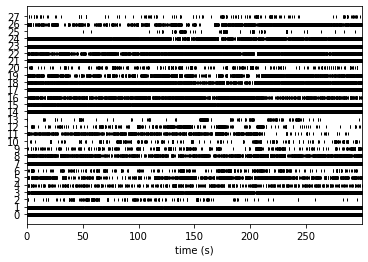

In [62]:
w_rs = sw.plot_rasters(sorting_IC)

# Running multiple sorter jobs in parallel

So far we have seen how to run one sorter at a time. SI provides a convenient launcher in order to run multiple sorters on multiple recordings with one line of code!

The `run_sorters()` function of the `sorter` module allows you to specify a list of sorters to use on a list (or dictionary) of parameters. The jobs are by default ran in a loop, but the `engine` argument enables to specify a parallel backend (`joblib` or `dask`) and relative parameters.

In the following example, we run the 2 jobs to run `herdingspikes` and `ironclust` in parallel:

In [63]:
sorting_outputs = ss.run_sorters(sorter_list=["herdingspikes", "ironclust"],
                                 recording_dict_or_list={"group0": recording_saved},
                                 working_folder="all_sorters",
                                 verbose=False,
                                 engine="joblib",
                                 engine_kwargs={'n_jobs': 2})

The returned `sorting_outputs` variable is a dictionary that has (rec_name, sorter_name) as keys, and the `SortingExtractor` objects as valus:

In [64]:
print(sorting_outputs.keys())

dict_keys([('group0', 'herdingspikes'), ('group0', 'ironclust')])


For the rest of the tutorial, let's pick the `ironclust` output:

In [65]:
sorting_IC = sorting_outputs[('group0', 'ironclust')]

## Spike sort in Docker containers
###  (Linux and MacOS only)

Some sorters are hard to install! To alleviate this headache, SI provides a built-in mechanism to run a spike sorting job in a docker container.

We are maintaining a set of sorter-specific docker files in the [spikeinterface-dockerfiles repo](<https://github.com/SpikeInterface/spikeinterface-dockerfiles>)
and most of the docker images are available on Docker Hub from the [SpikeInterface organization](<https://hub.docker.com/orgs/spikeinterface/repositories>).

Running spike sorting in a docker container just requires to:

1. have docker installed
2. have docker python SDK installed (`pip install docker`)

When docker is installed, you can simply run the sorter in a specified docker image:

In [66]:
print(ss.installed_sorters())

['herdingspikes', 'ironclust']


In [78]:
sorting_SC = ss.run_spykingcircus(recording_saved, output_folder="results_SC",
                                  docker_image="spikeinterface/spyking-circus-base:1.0.7", 
                                  verbose=True)

Installing spikeinterface from sources in spikeinterface/spyking-circus-base:1.0.7
Running sorter in spikeinterface/spyking-circus-base:1.0.7


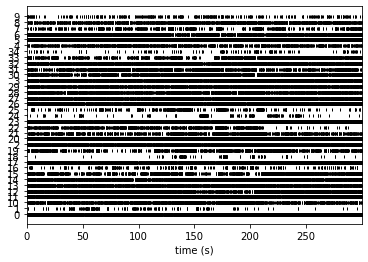

In [68]:
sw.plot_rasters(sorting_SC)

# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

**NEW** In the SI API, waveforms are extracted using the `WaveformExtractor` class in the `core` module.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates.
Let's see how it works.

To extract the waveforms, we can run:

In [69]:
si.extract_waveforms?

In [70]:
we = si.extract_waveforms(recording_saved, sorting_IC, folder="wf_IC", progress_bar=True,
                          n_jobs=1, total_memory="500M", overwrite=True)
print(we)

extract waveforms: 100%|########################################################################################################################################################################################################################| 1/1 [00:01<00:00,  1.41s/it]

WaveformExtractor: 16 channels - 28 units - 1 segments
  before:60 after80 n_per_units: 500


Now all waveforms are computed and stored in the provided `wf_IC` folder. We can now retrieve waveforms and templates easily:

In [71]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
template0 = we.get_template(unit_id=0)
print(f"Template shape: {template0.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

Waveforms shape: (500, 140, 16)
Template shape: (140, 16)
All templates shape: (28, 140, 16)


For waveforms, the dimension is (num_spikes, num_samples, num_channels), while each template has dimension (num_samples, num_channels). Note that the number of spikes in this case is 500..we'll get back to it later!

The `WaveformExtractor` is also compatible with several `widgets` to visualize the spike sorting output:

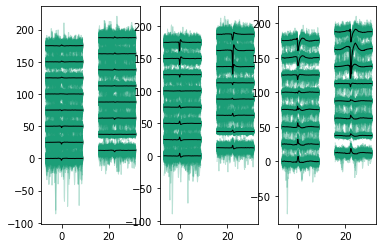

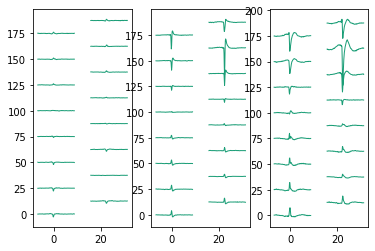

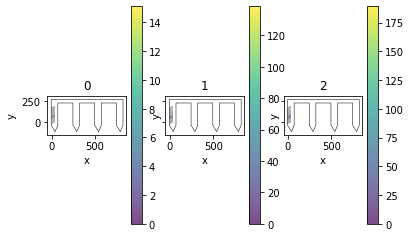

In [72]:
w = sw.plot_unit_waveforms(we, unit_ids=[0,1,2])
w = sw.plot_unit_templates(we, unit_ids=[0,1,2])
w = sw.plot_unit_probe_map(we, unit_ids=[0,1,2])

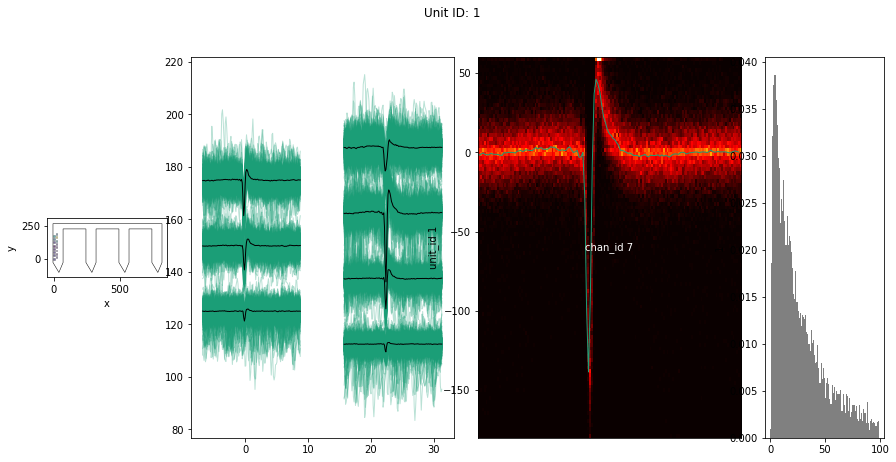

In [74]:
w = sw.plot_unit_summary(we, unit_id=1)

As we noticed before, the number of spikes for the waveforms is 500. Let's check the number of spikes for other waveforms:

In [75]:
for unit in sorting_IC.get_unit_ids():
    waveforms = we.get_waveforms(unit_id=unit)
    spiketrain = sorting_IC.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 500 - num spikes: 45391
Unit 1 - num waveforms: 500 - num spikes: 8310
Unit 2 - num waveforms: 236 - num spikes: 236
Unit 3 - num waveforms: 500 - num spikes: 4608
Unit 4 - num waveforms: 482 - num spikes: 482
Unit 5 - num waveforms: 499 - num spikes: 1607
Unit 6 - num waveforms: 439 - num spikes: 439
Unit 7 - num waveforms: 500 - num spikes: 7773
Unit 8 - num waveforms: 500 - num spikes: 1643
Unit 9 - num waveforms: 500 - num spikes: 532
Unit 10 - num waveforms: 335 - num spikes: 335
Unit 11 - num waveforms: 500 - num spikes: 918
Unit 12 - num waveforms: 500 - num spikes: 595
Unit 13 - num waveforms: 203 - num spikes: 203
Unit 14 - num waveforms: 500 - num spikes: 6318
Unit 15 - num waveforms: 500 - num spikes: 4437
Unit 16 - num waveforms: 500 - num spikes: 2381
Unit 17 - num waveforms: 500 - num spikes: 28488
Unit 18 - num waveforms: 500 - num spikes: 3175
Unit 19 - num waveforms: 500 - num spikes: 2109
Unit 20 - num waveforms: 412 - num spikes: 412
Unit 21 -

No units have more than 500 spikes! This is because by default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we can use the `max_spikes_per_unit` argument:

In [76]:
we_all = si.extract_waveforms(recording_saved, sorting_IC, folder="wf_IC_all", 
                              max_spikes_per_unit=None, progress_bar=True)

extract waveforms: 100%|########################################################################################################################################################################################################################| 1/1 [00:09<00:00,  9.05s/it]


In [77]:
for unit in sorting_IC.get_unit_ids():
    waveforms = we_all.get_waveforms(unit_id=unit)
    spiketrain = sorting_IC.get_unit_spike_train(unit)
    print(f"Unit {unit} - num waveforms: {waveforms.shape[0]} - num spikes: {len(spiketrain)}")

Unit 0 - num waveforms: 45391 - num spikes: 45391
Unit 1 - num waveforms: 8310 - num spikes: 8310
Unit 2 - num waveforms: 236 - num spikes: 236
Unit 3 - num waveforms: 4608 - num spikes: 4608
Unit 4 - num waveforms: 482 - num spikes: 482
Unit 5 - num waveforms: 1606 - num spikes: 1607
Unit 6 - num waveforms: 439 - num spikes: 439
Unit 7 - num waveforms: 7773 - num spikes: 7773
Unit 8 - num waveforms: 1643 - num spikes: 1643
Unit 9 - num waveforms: 532 - num spikes: 532
Unit 10 - num waveforms: 335 - num spikes: 335
Unit 11 - num waveforms: 918 - num spikes: 918
Unit 12 - num waveforms: 595 - num spikes: 595
Unit 13 - num waveforms: 203 - num spikes: 203
Unit 14 - num waveforms: 6318 - num spikes: 6318
Unit 15 - num waveforms: 4437 - num spikes: 4437
Unit 16 - num waveforms: 2381 - num spikes: 2381
Unit 17 - num waveforms: 28488 - num spikes: 28488
Unit 18 - num waveforms: 3174 - num spikes: 3175
Unit 19 - num waveforms: 2109 - num spikes: 2109
Unit 20 - num waveforms: 412 - num spikes:

Now waveforms have been extracted for all spikes! Let's move on to explore the postprocessing capabilities of the `toolkit` module.

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `toolkit` module.

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [79]:
pc = st.compute_principal_components(we, n_components=3)

In [80]:
pc0 = pc.get_components(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_components()
print(f"All PC scores shape: {all_pcs.shape}")

PC scores shape: (500, 3, 16)
All PC scores shape: (12471, 3, 16)


For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 
The `get_all_components()` function returns an array with the label/unit id for each component (`all_labels`) and an array of dimension (num_all_samples, num_components, num_channels). 

### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [81]:
amplitudes = st.get_spike_amplitudes(we, outputs="concatenated", progress_bar=True)

extract amplitudes: 100%|#######################################################################################################################################################################################################################| 1/1 [00:01<00:00,  1.43s/it]


By default, all amplitudes are concatenated in one array.

The correspinding spike times and labels can be easily retrieved as:

In [82]:
all_spike_times, all_spike_labels = sorting_IC.get_all_spike_trains()[0]

The [0] index is to select the first segment. In case of multiple segments each element will correspond to a different segment and will contain spike times and labels for that segment.


### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `toolkit` allows one to compute several of these metrics:

In [83]:
print(st.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope']


In [84]:
template_metrics = st.calculate_template_metrics(we)
display(template_metrics)

peak_to_valley peak_trough_ratio half_width repolarization_slope  \
0           0.001         -0.135294     0.0002         63982.717233   
1          0.0002         -0.332852     0.0002       1309441.518784   
2         0.00085         -0.244586    0.00025        464698.694845   
3          0.0006         -0.283581     0.0003        145868.331818   
4          0.0007         -0.206789     0.0002        122630.661513   
5          0.0006         -0.296934     0.0003        410948.416534   
6          0.0006          -0.30703       None        344487.366449   
7         0.00025          -0.29418     0.0002        396710.987091   
8          0.0007          -0.30515     0.0003        145675.588449   
9         0.00065         -0.269282     0.0002        374661.153885   
10         0.0006         -0.299851    0.00025        384854.091576   
11         0.0003         -0.331674     0.0002        519956.794739   
12         0.0007         -0.218099     0.0002        465009.884714   
13         0.0006         -0.270555     0.0002        595974.834442   
14        0.00065         -0.310698     0.0003        165355.423746   
15         0.0005         -0.245895    0.00025        169191.234725   
16         0.0002         -0.375667     0.0002        738319.511414   
17        0.00085         -0.084767    0.00025        123784.205914   
18         0.0006         -0.320886    0.00035        276997.278214   
19         0.0006          -0.28493     0.0003        395673.937798   
20        0.00065         -0.260596    0.00025        581029.041835   
21         0.0008         -0.206646     0.0002         110163.49256   
22        0.00065         -0.295346    0.00025        268981.529304   
23         0.0006         -0.301328    0.00035        117203.611192   
24         0.0006         -0.320312    0.00025        453887.429919   
25         0.0006         -0.315812    0.00025       1276736.419201   
26        0.00065         -0.321066     0.0003        432786.057336   
27         0.0006         -0.280481     0.0002       1066320.697467   

   recovery_slope  
0    -2248.684517  
1   -68061.881652  
2   -70677.701992  
3    -19030.36891  
4    -11102.86655  
5   -55927.548126  
6   -49035.183728  
7   -19535.574489  
8   -20073.488508  
9   -46060.606626  
10  -52740.475854  
11  -45309.833631  
12  -52597.326593  
13  -54407.261691  
14  -23926.728647  
15  -13851.558968  
16  -45641.395108  
17   -4764.352845  
18  -43975.477617  
19  -45426.646474  
20  -59187.885578  
21  -10479.143861  
22  -38851.855414  
23  -14538.919889  
24  -65576.679984  
25 -176099.462656  
26  -62263.912746  
27 -167795.595651

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Validation and curation <a class="anchor" id="curation"></a>

The `toolkit` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

Let's see what metrics are available:

In [85]:
print(st.get_quality_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'amplitude_cutoff']


In [86]:
qc = st.compute_quality_metrics(we_all, waveform_principal_component=pc)

In [87]:
display(qc)

num_spikes  firing_rate  presence_ratio        snr  isi_violations_rate  \
0        45391   151.303333            1.00   1.144547            36.860000   
1         8310    27.700000            1.00   8.261318             0.106667   
2          236     0.786667            0.59  13.594437             0.000000   
3         4608    15.360000            1.00   5.381992             0.103333   
4          482     1.606667            1.00   3.566878             0.010000   
5         1607     5.356667            0.99  14.137097             0.010000   
6          439     1.463333            0.85  13.427126             0.000000   
7         7773    25.910000            1.00   3.690491             0.480000   
8         1643     5.476667            1.00   5.266601             0.030000   
9          532     1.773333            0.86  10.223853             0.000000   
10         335     1.116667            0.74  11.857692             0.003333   
11         918     3.060000            0.86   7.722658             0.000000   
12         595     1.983333            0.81  10.718793             0.003333   
13         203     0.676667            0.46   8.127218             0.000000   
14        6318    21.060000            1.00   5.244802             0.383333   
15        4437    14.790000            1.00   3.670913             0.226667   
16        2381     7.936667            1.00   5.926595             0.013333   
17       28488    94.960000            1.00   2.379437            15.190000   
18        3175    10.583333            1.00  11.287271             0.020000   
19        2109     7.030000            0.96   9.662143             0.006667   
20         412     1.373333            0.83  13.849978             0.000000   
21       12532    41.773333            1.00   2.877862             1.770000   
22        3269    10.896667            1.00   8.776991             0.030000   
23        7891    26.303333            1.00   3.737518             0.566667   
24        3808    12.693333            1.00  11.513832             0.013333   
25         163     0.543333            0.33  29.976398             0.000000   
26        2214     7.380000            0.94   9.842435             0.020000   
27         203     0.676667            0.63  25.422354             0.003333   

    isi_violations_count  amplitude_cutoff  isolation_distance       l_ratio  \
0                  11058          0.000044           32.858630  4.068578e+00   
1                     32          0.000031           86.313790  3.873600e-02   
2                      0          0.001097          159.523423  1.153886e-06   
3                     31          0.003711           53.040399  8.530745e-01   
4                      3          0.016999           41.745593  1.969057e+00   
5                      3          0.000161           71.039454  1.162806e-01   
6                      0          0.016789           68.660805  1.434822e-01   
7                    144          0.000033           48.786354  1.145352e+00   
8                      9          0.000158           51.624181  8.533062e-01   
9                      0          0.000488           72.300065  2.053721e-01   
10                     1          0.023759           56.474772  6.098082e-01   
11                     0          0.023675           86.292260  8.376376e-02   
12                     1          0.024067           89.933698  5.205857e-02   
13                     0          0.001275           98.401796  1.949630e-02   
14                   115          0.000041           42.776901  1.788787e+00   
15                    68          0.001157           43.916357  1.618652e+00   
16                     4          0.001220           47.853411  1.206771e+00   
17                  4557          0.000009           40.235048  2.497414e+00   
18                     6          0.006793           97.328297  3.377842e-03   
19                     2          0.004223           80.419177  8.105804e-02   
20                     0        

For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qc` dataframe based on some thresholds.

Here, we'll only keep units with an SNR > 5 and an ISI violation threshold < 0.2:

In [88]:
snr_thresh = 5
isi_viol_thresh = 0.2

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [89]:
our_query = f"snr > {snr_thresh} & isi_violations_rate < {isi_viol_thresh}"
print(our_query)

snr > 5 & isi_violations_rate < 0.2


and then we can use the query to select units:

In [90]:
keep_units = qc.query(our_query)
keep_unit_ids = keep_units.index.values

In [91]:
sorting_auto = sorting_IC.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting_IC.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

Number of units before curation: 28
Number of units after curation: 20


# 8. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `SortingExtractor` with only the units in agreement.

In [92]:
mcmp = sc.compare_multiple_sorters([sorting_HS, sorting_IC, sorting_SC], ['HS', 'IC', 'SC'], 
                                   spiketrain_mode='union', verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing:  HS  and  IC
  Comparing:  HS  and  SC
  Comparing:  IC  and  SC
Multicomaprison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomaprison step 4: extract agreement from graph


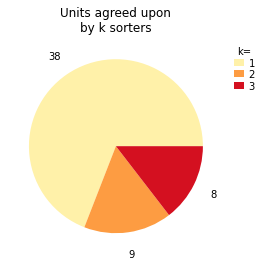

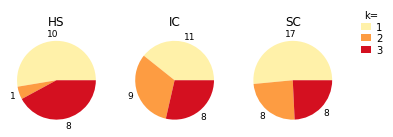

In [93]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

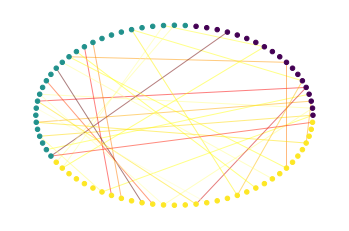

In [94]:
sw.plot_multicomp_graph(mcmp)

In [95]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

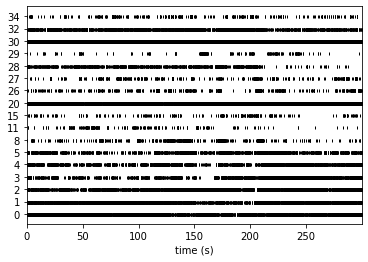

In [96]:
sw.plot_rasters(agreement_sorting)

# 9. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [97]:
from spikeinterface.exporters import export_to_phy

In [98]:
export_to_phy(we_all, output_folder='phy_IC',
              progress_bar=True, total_memory='100M')

write_binary_recording with n_jobs 1  chunk_size 1562500


extract PCs: 100%|##############################################################################################################################################################################################################################| 4/4 [02:31<00:00, 37.94s/it]

Run:
phy template-gui  /Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/spiketutorials/Official_Tutorial_SI_0.90_Aug2021/phy_IC/params.py


In [99]:
%%capture --no-display
!phy template-gui phy_IC/params.py

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

In [100]:
sorting_IC_phy_curated = se.PhySortingExtractor('phy_IC/', exclude_cluster_groups=['noise'])

In [101]:
print(f"Number of units before curation: {len(sorting_IC.get_unit_ids())}")
# in manual curation, 3 units were labeled as noise:
print(f"Number of units after curation: {len(sorting_IC_phy_curated.get_unit_ids())}")

Number of units before curation: 28
Number of units after curation: 25


## Export spike sorting report

In [102]:
from spikeinterface.exporters import export_report

/Users/abuccino/Documents/Codes/spike_sorting/spikeinterface/forks/alejoe91/spikeinterface/spikeinterface/exporters/report.py:89: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(constrained_layout=False, figsize=(15, 7), )


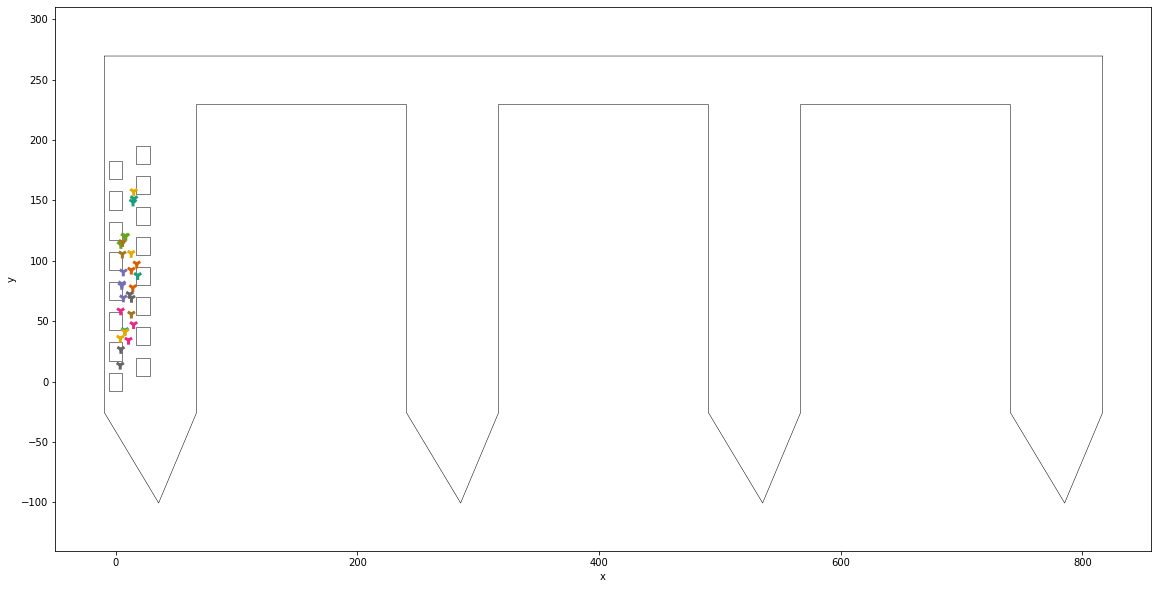

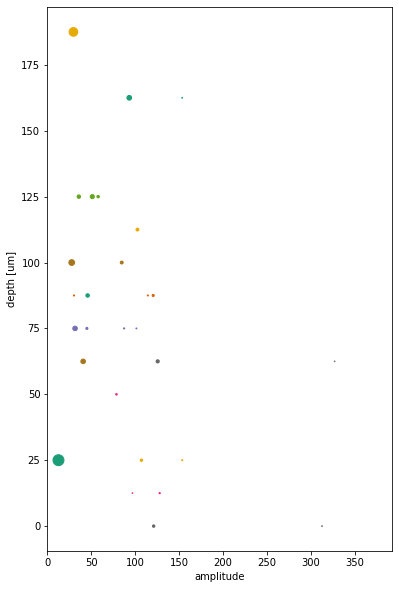

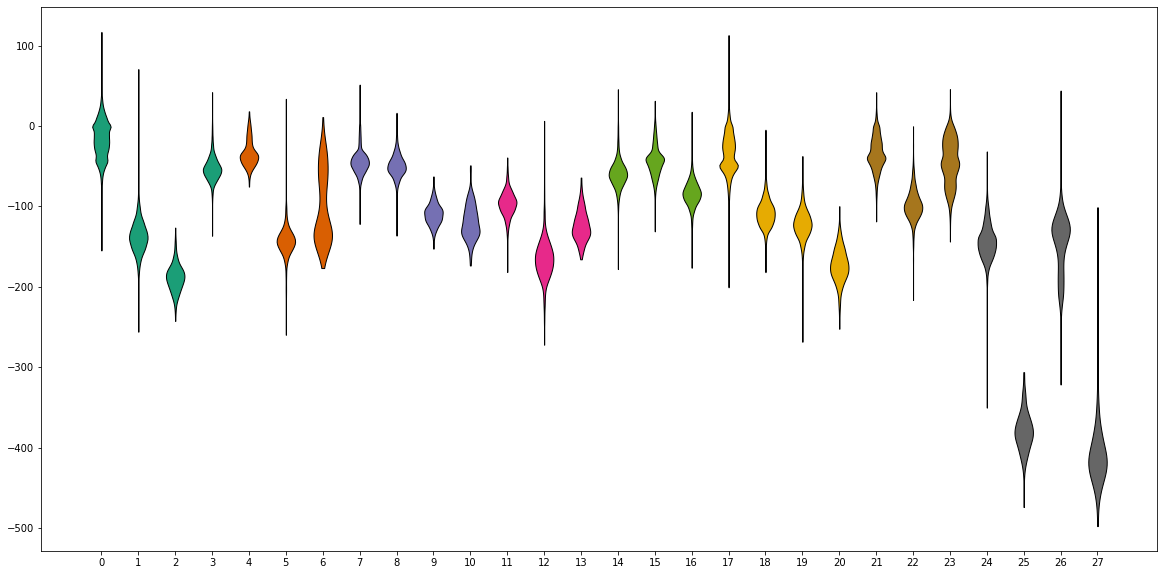

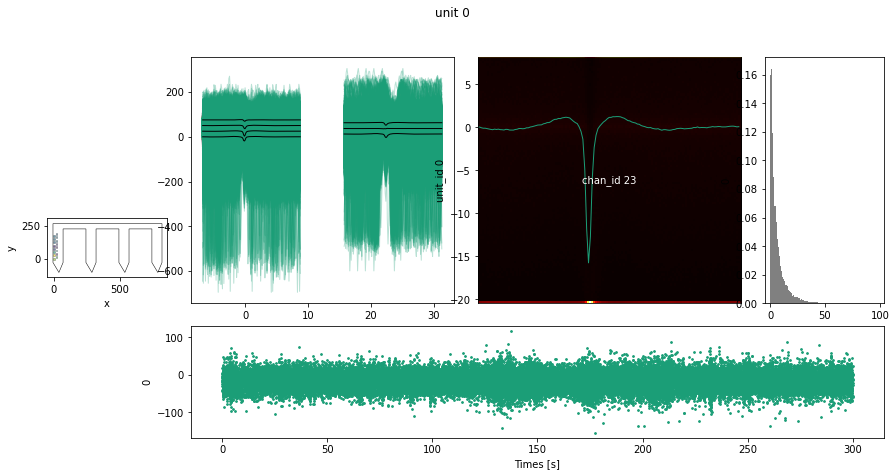

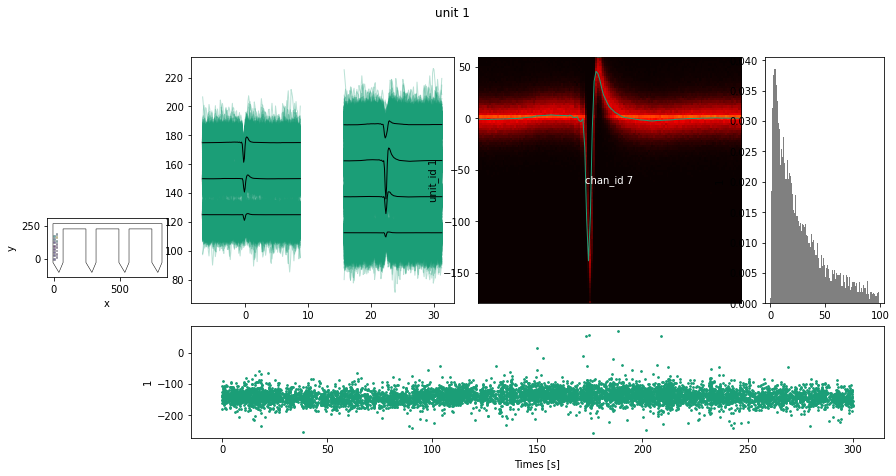

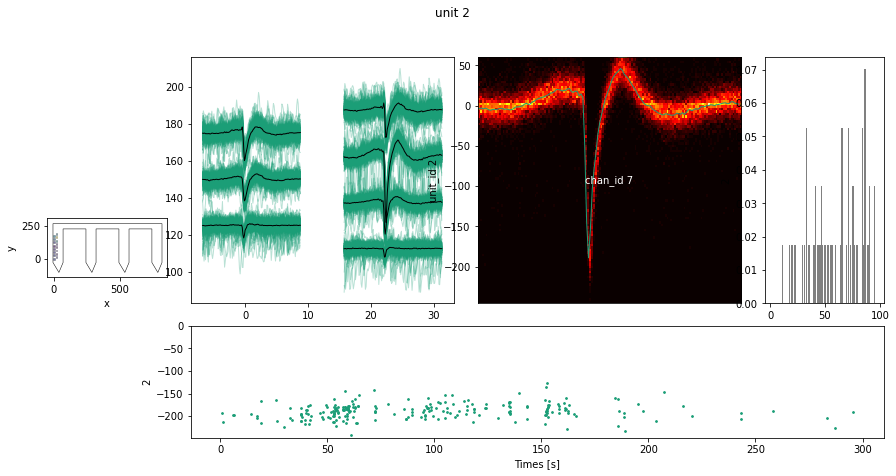

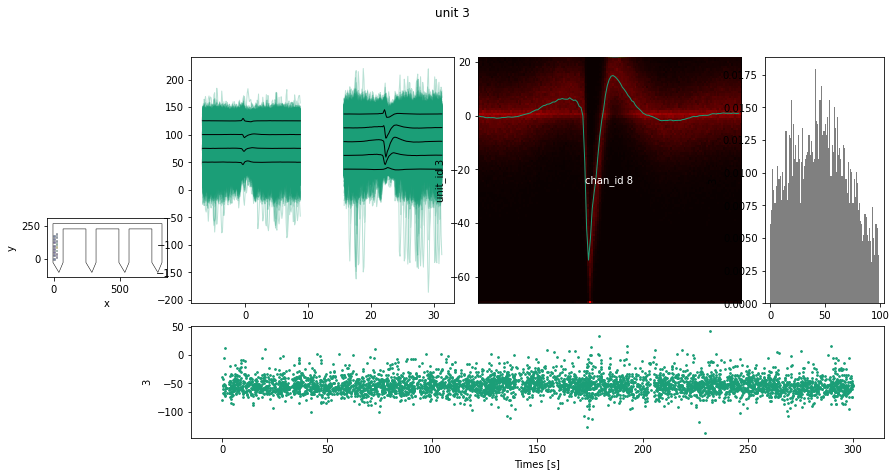

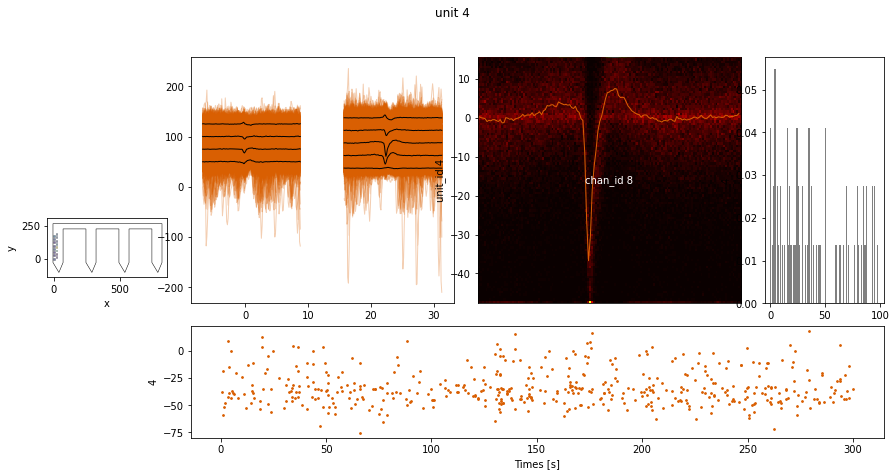

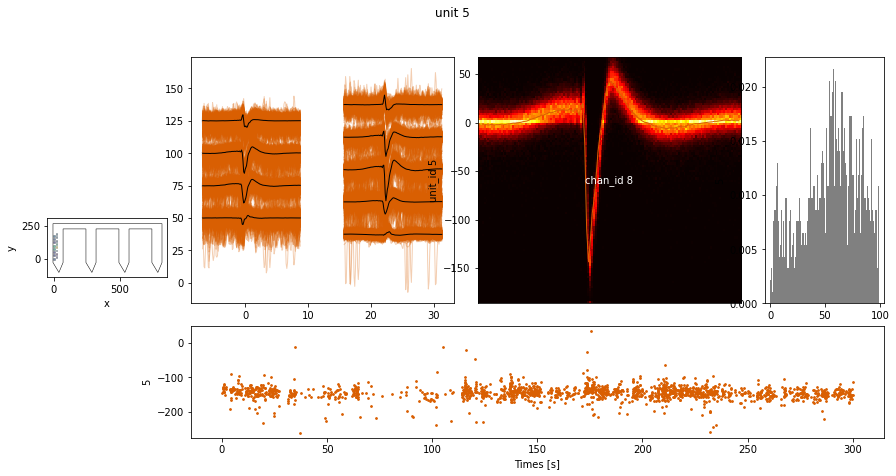

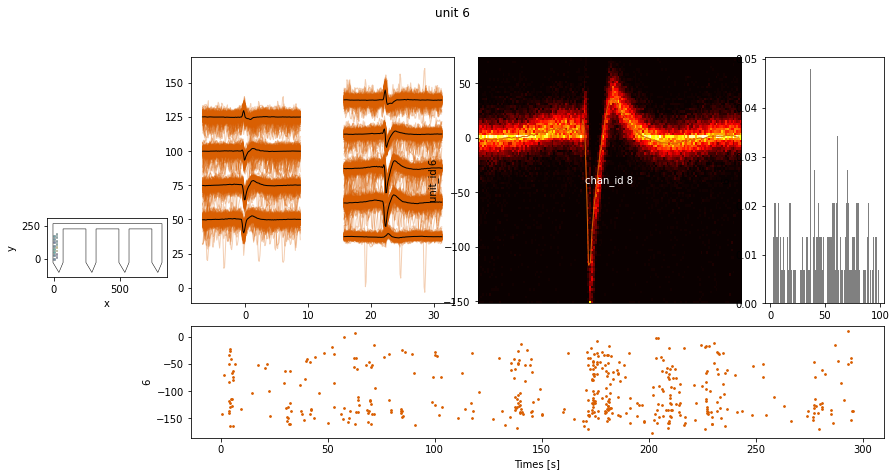

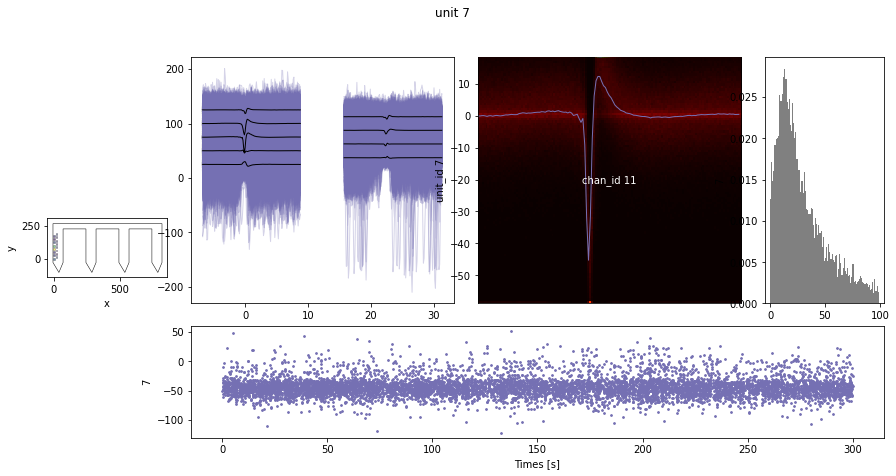

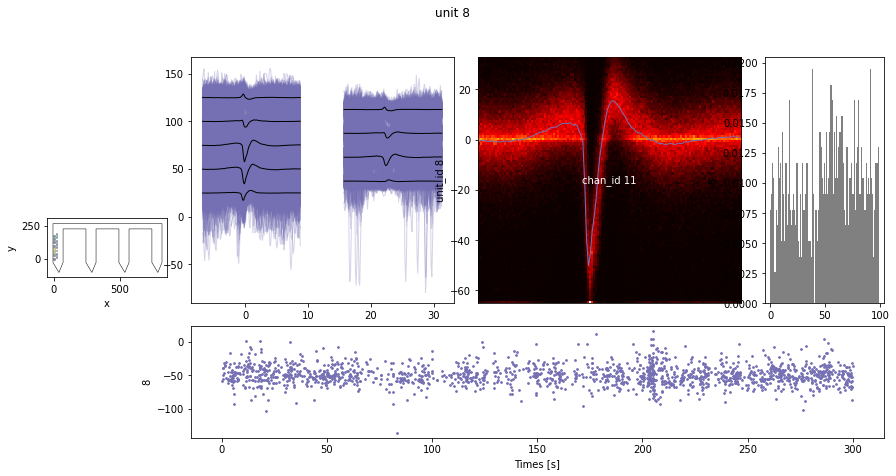

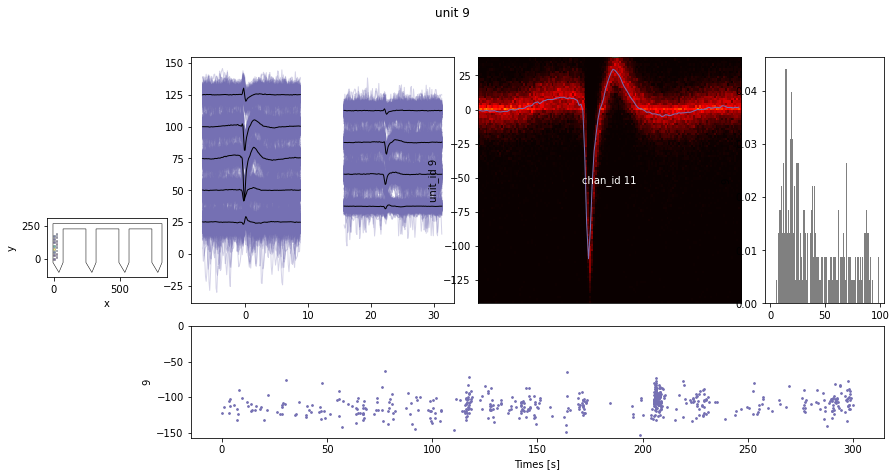

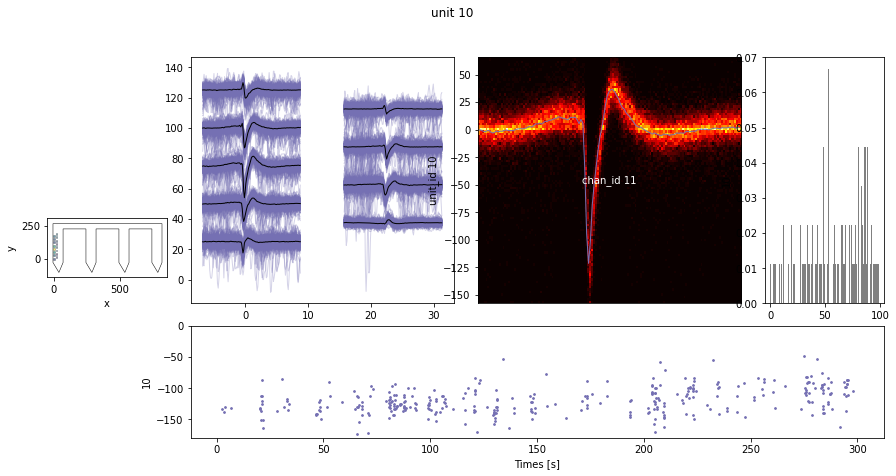

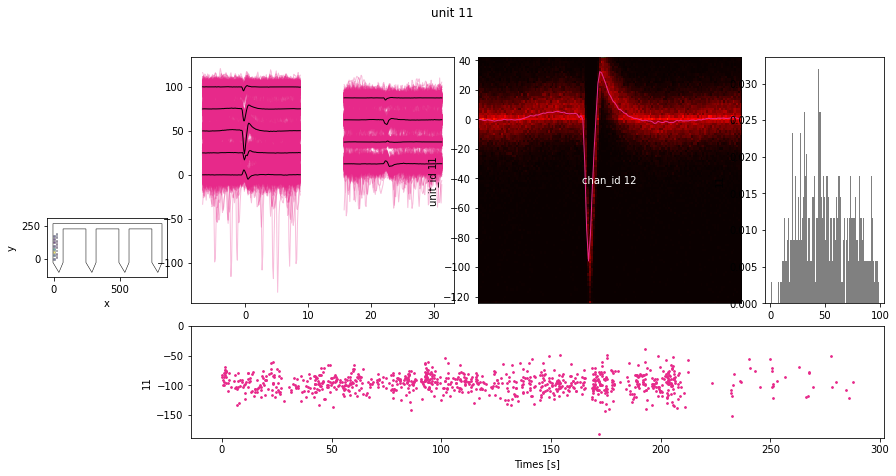

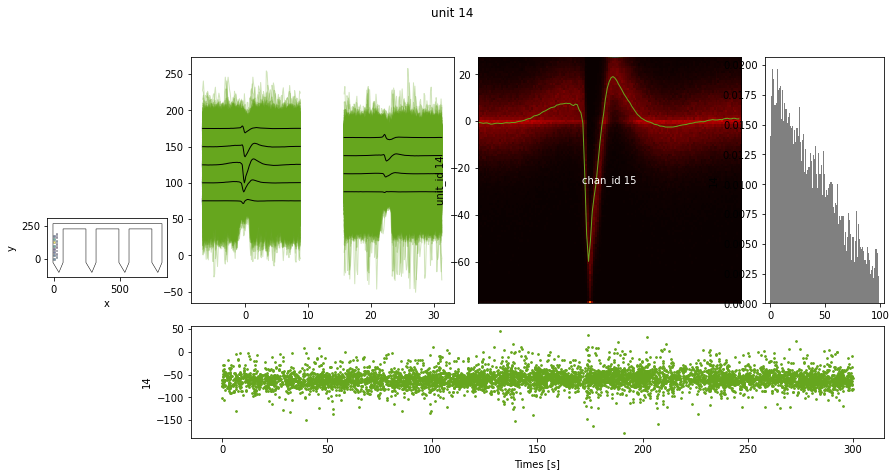

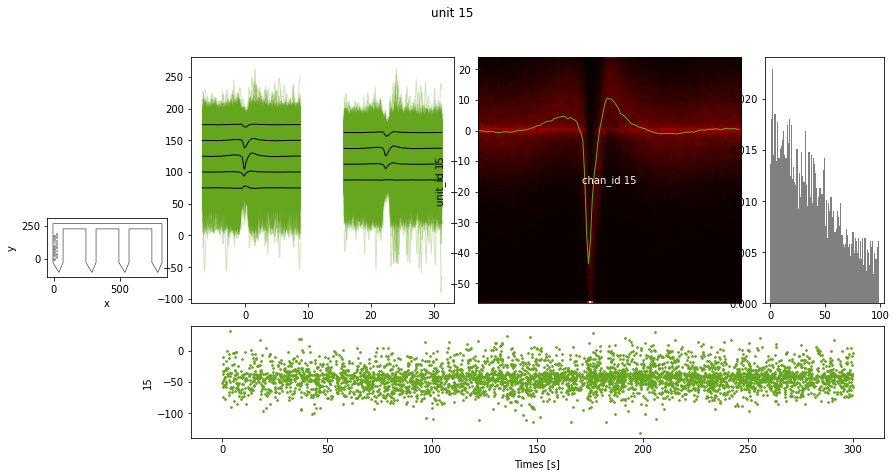

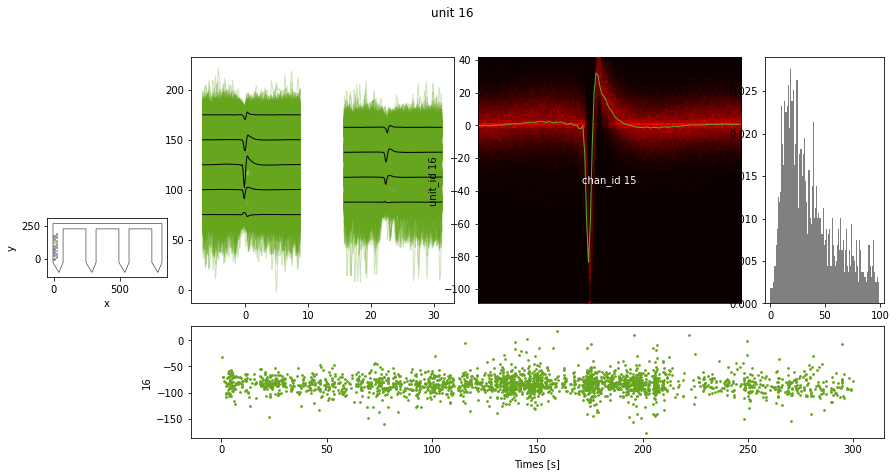

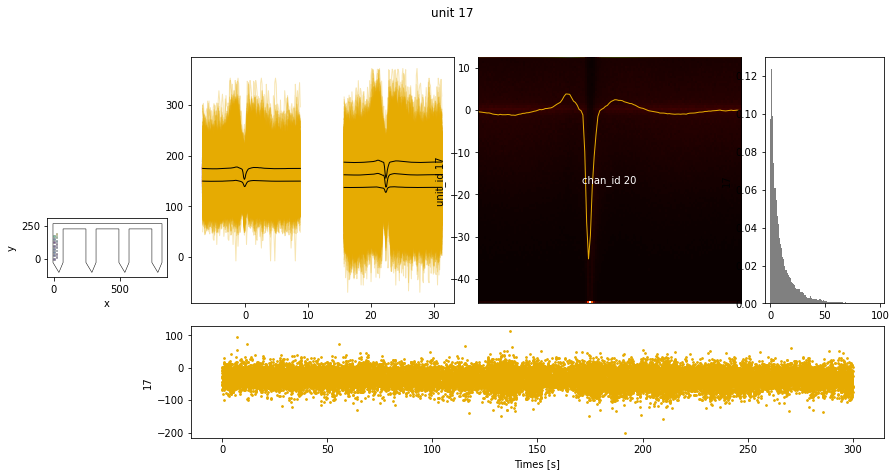

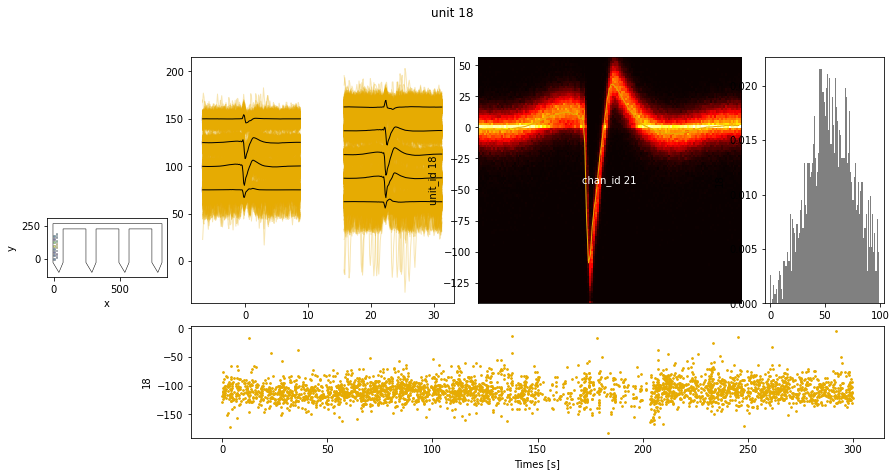

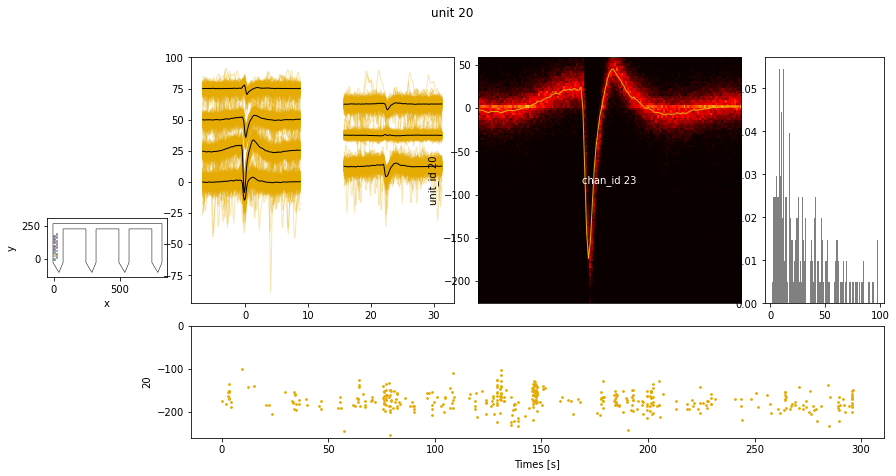

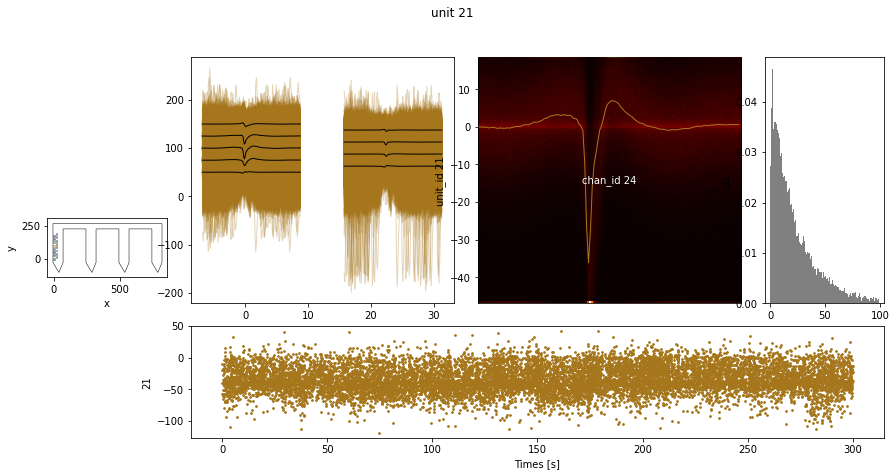

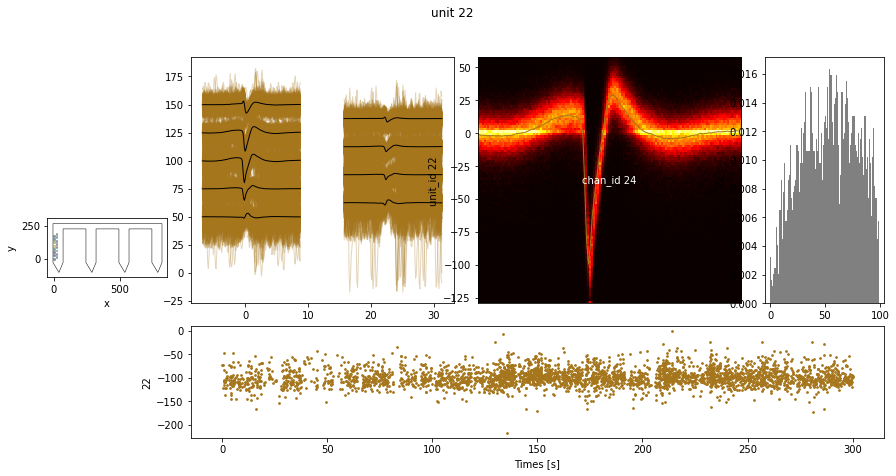

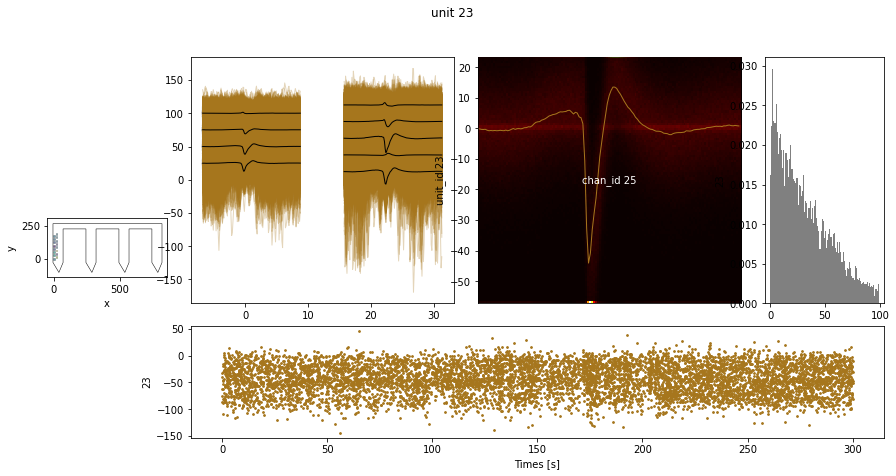

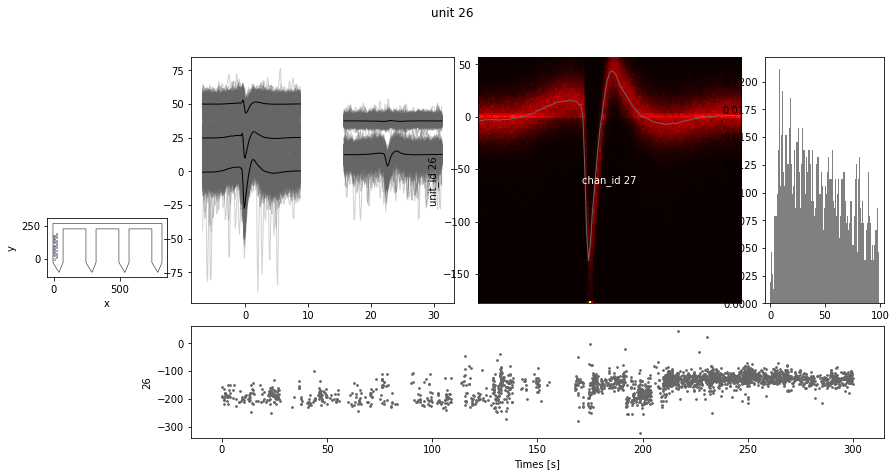

In [103]:
export_report(waveform_extractor=we_all, output_folder="SI_report", format="pdf", 
              metrics=qc)

In [104]:
!ls SI_report

amplitudes_distribution.pdf  unit_localization.pdf
quality metrics.csv          units
unit list.csv                units_depth_vs_amplitude.pdf


In [105]:
!ls SI_report/units/

0.pdf  11.pdf 14.pdf 17.pdf 2.pdf  22.pdf 25.pdf 3.pdf  6.pdf  9.pdf
1.pdf  12.pdf 15.pdf 18.pdf 20.pdf 23.pdf 26.pdf 4.pdf  7.pdf
10.pdf 13.pdf 16.pdf 19.pdf 21.pdf 24.pdf 27.pdf 5.pdf  8.pdf


## Export to NWB (coming soon in version 0.91)

Similarly to the previous SI versions, the exporter modules will allow to export to NWB SI objects. The `export_to_nwb` function will rely on an external implementation from [nwb-conversion-tools](https://github.com/catalystneuro/nwb-conversion-tools).

The `export_to_nwb` function is a milestone for spikeinterface version 0.91.

In [ ]:
from spikeinterface.exporters import export_to_nwb

In [ ]:
# export a single object, e.g. a Recording
export_to_nwb(recording, metadata=some_metadata)

# export a list of paired objects (recording + sorting)
export_to_nwb(objects_to_write=[recording, sorting], metadata=some_metadata)

# export a waveform extractor (recording + sorting + waveforms)
export_to_nwb(we_full, metadata=some_metadata)